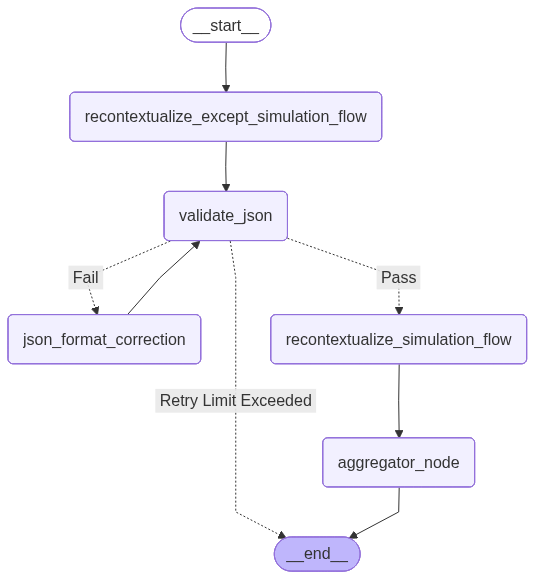

In [1]:
from utlis import build_workflow, create_initial_state
import json
from langgraph.checkpoint.memory import InMemorySaver # For Persistance
import os

checkpointer = InMemorySaver()

chain = build_workflow(checkpoints=checkpointer)

chain

In [2]:
print("Initializing state...")
with open("problem_statement/POC_sim_D.json", "r") as f:
    data = json.load(f)
        
        
state = create_initial_state(
    current_scenario=(
        '''A strategy team at HarvestBowls is facing a drop in foot traffic after Nature\'s Crust introduced a $1 value menu. As a business consultant, learners must analyze the market shake-up, assess possible strategic responses,and recommend a plan that helps HarvestBowls maintain its loyal customer base, safeguard profitability, and uphold its commitment to serving fresh, organic, and wholesome fast food.'''
    ),
    new_scenario=(
        '''FlexFit Gym memberships decline after rival BodyWorks introduces steeply discounted annual packages. Learners must recommend whether FlexFit should compete on price, expand digital offerings, or reinforce its premium brand.'''
    ),
    scenario_json=data
)

result_state = chain.invoke(state,{"configurable": {"thread_id": "1"}})

Initializing state...
=== Recontextualization Start ===
From Scenario: A strategy team at HarvestBowls is facing a drop in foot traffic after Nature's Crust introduced a $1 value menu. As a business consultant, learners must analyze the market shake-up, assess possible strategic responses,and recommend a plan that helps HarvestBowls maintain its loyal customer base, safeguard profitability, and uphold its commitment to serving fresh, organic, and wholesome fast food.
To Scenario: FlexFit Gym memberships decline after rival BodyWorks introduces steeply discounted annual packages. Learners must recommend whether FlexFit should compete on price, expand digital offerings, or reinforce its premium brand.

✓ Recontextualization completed in 13.61 seconds
Validating JSON schema...
✓ JSON Schema Validation OK
Recontextualizing simulation flow
✓ Recontextualization completed in 39.67 seconds
✓ Aggregator Node: Starting aggregation process
✓ Aggregator Node: Aggregation process completed in 0.05

In [2]:
# config = {"configurable": {"thread_id": "1"}}
# list(chain.get_state_history(config))[0].config

# config = {"configurable": {"thread_id": "1", "checkpoint_id": '1f0d5116-dacc-6622-8003-65442ecf32da'}}
# chain.invoke(None, config=config)

In [4]:
os.makedirs("results", exist_ok=True)

In [5]:
output_path = "results/output.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(result_state['output_json'], f, indent=2, ensure_ascii=False)

In [ ]:
changed_fields_path = "results/changed_fields.json"
with open(changed_fields_path, "w", encoding="utf-8") as f:
    json.dump(result_state['changed_fields'], f, indent=2, ensure_ascii=False)

In [3]:
import json
import os

from langgraph.checkpoint.memory import InMemorySaver # For Persistance

from utlis import build_workflow, create_initial_state

checkpointer = InMemorySaver()

chain = build_workflow(checkpoints=checkpointer)

print("Initializing state...")
with open("problem_statement/POC_sim_D.json", "r") as f:
    data = json.load(f)
        
        
state = create_initial_state(
    current_scenario=(
        '''A strategy team at HarvestBowls is facing a drop in foot traffic after Nature\'s Crust introduced a $1 value menu. As a business consultant, learners must analyze the market shake-up, assess possible strategic responses,and recommend a plan that helps HarvestBowls maintain its loyal customer base, safeguard profitability, and uphold its commitment to serving fresh, organic, and wholesome fast food.'''
    ),
    new_scenario=(
        '''FlexFit Gym memberships decline after rival BodyWorks introduces steeply discounted annual packages. Learners must recommend whether FlexFit should compete on price, expand digital offerings, or reinforce its premium brand.'''
    ),
    scenario_json=data
)

try:
    result_state = chain.invoke(state,{"configurable": {"thread_id": "1"}})
except Exception as e:
    print(f"Error: {e}")
    print("The State is saved in the memory : results/state.json")
    config = {"configurable": {"thread_id": "1"}}
    temp_state = list(chain.get_state_history(config))[0].value
    with open("results/state.json", "w", encoding="utf-8") as f:
        json.dump(temp_state, f, indent=2, ensure_ascii=False)



# Save the output to a JSON file
os.makedirs("results", exist_ok=True)
output_path = "results/output.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(result_state['output_json'], f, indent=2, ensure_ascii=False)
    
# Save the Change Log to a JSON file
changed_fields_path = "results/changed_fields.json"
with open(changed_fields_path, "w", encoding="utf-8") as f:
    json.dump(result_state['changed_fields'], f, indent=2, ensure_ascii=False)


Initializing state...
=== Recontextualization Start ===
From Scenario: A strategy team at HarvestBowls is facing a drop in foot traffic after Nature's Crust introduced a $1 value menu. As a business consultant, learners must analyze the market shake-up, assess possible strategic responses,and recommend a plan that helps HarvestBowls maintain its loyal customer base, safeguard profitability, and uphold its commitment to serving fresh, organic, and wholesome fast food.
To Scenario: FlexFit Gym memberships decline after rival BodyWorks introduces steeply discounted annual packages. Learners must recommend whether FlexFit should compete on price, expand digital offerings, or reinforce its premium brand.

✓ Recontextualization completed in 14.46 seconds
Validating JSON schema...
✓ JSON Schema Validation OK
Recontextualizing simulation flow
✓ Recontextualization completed in 40.79 seconds
✓ Aggregator Node: Starting aggregation process
JSON conforms to the schema:
✓ Aggregator Node: Aggregat